In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## <Class8 : furnitue>

In [2]:
Class8 = pd.read_csv('C:/Users/wjssm/Desktop/lpoint/modeling/Class8.csv')
Class8['Date'] = pd.date_range('2018-04-01', '2018-09-30').strftime('%Y-%m-%d')
Class8['Date'] =pd.to_datetime(Class8['Date'])
Class8 = Class8.set_index('Date')
Class8.head()

,BUY_CT_sum,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,kitchen
Date,,,,,
2018-04-01,1995,75.125000,1653.928679,35.157186,112.933333
2018-04-02,1910,65.013571,1505.189787,35.250212,126.133333
2018-04-03,2036,76.665635,1659.884914,35.386997,123.200000
2018-04-04,1419,60.346078,1288.602362,34.333333,126.133333
2018-04-05,1946,66.628085,1465.965870,34.936170,121.733333


In [3]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    diff.append(dataset[0])
    for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
    return pd.Series(diff)

# inverse_difference
def inverse_difference(diff, interval=1):
    origin = list()
    origin.append(diff[0])
    for i in range(interval, len(diff)):
            value = diff[i] + origin[i - interval]
            origin.append(value)
    return pd.Series(origin)

In [4]:
Y = Class8['BUY_CT_sum']

In [5]:
#remove original Y
Class8.drop(columns=['BUY_CT_sum'],inplace=True)
Class8.rename(columns = {'furniture' : 'naver_click'}, inplace=True)
Class8.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,kitchen
Date,,,,
2018-04-01,75.125000,1653.928679,35.157186,112.933333
2018-04-02,65.013571,1505.189787,35.250212,126.133333
2018-04-03,76.665635,1659.884914,35.386997,123.200000
2018-04-04,60.346078,1288.602362,34.333333,126.133333
2018-04-05,66.628085,1465.965870,34.936170,121.733333


In [6]:
def minmax(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def inverse_minmax(norm,dataset):
    deNorm=norm*(dataset.max()-dataset.min())+dataset.min()
    return deNorm

#### 변수 조합

In [7]:
#TOT_SESS_HR_V_mean 역수
Class8['TOT_SESS_HR_V_mean'] = 1000/Class8['TOT_SESS_HR_V_mean']
Class8.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,kitchen
Date,,,,
2018-04-01,75.125000,0.604621,35.157186,112.933333
2018-04-02,65.013571,0.664368,35.250212,126.133333
2018-04-03,76.665635,0.602451,35.386997,123.200000
2018-04-04,60.346078,0.776035,34.333333,126.133333
2018-04-05,66.628085,0.682144,34.936170,121.733333


#### scaled

In [8]:
scaled_df1=minmax(Class8)
#(xi–mean(x))/stdev(x)
scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,kitchen
Date,,,,
2018-04-01,0.339109,0.348601,0.438001,0.64
2018-04-02,0.172400,0.517906,0.466061,0.82
2018-04-03,0.364509,0.342453,0.507319,0.78
2018-04-04,0.095446,0.834335,0.189505,0.82
2018-04-05,0.199018,0.568278,0.371337,0.76


In [9]:
scaled_Y = minmax(Y)

scaled_df1 = pd.concat([scaled_df1, scaled_Y], axis = 1)
scaled_df1.rename(columns={'BUY_CT_sum':'Y'}, inplace=True)

scaled_df1.head()

,HITS_SEQ_mean,TOT_SESS_HR_V_mean,CLNT_AGE_mean,kitchen,Y
Date,,,,,
2018-04-01,0.339109,0.348601,0.438001,0.64,0.587984
2018-04-02,0.172400,0.517906,0.466061,0.82,0.555039
2018-04-03,0.364509,0.342453,0.507319,0.78,0.603876
2018-04-04,0.095446,0.834335,0.189505,0.82,0.364729
2018-04-05,0.199018,0.568278,0.371337,0.76,0.568992


In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

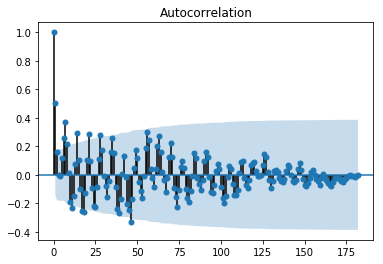

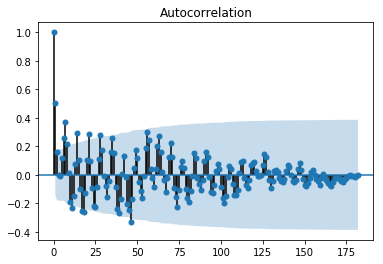

In [11]:
#original data
plot_acf(Y, ax = plt.gca())

#### modeling

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\Users\wjssm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
#scaled_data : scaled한 데이터. 사용하려는 변수 + 마지막 칼럼은 Y
#n : 사용하는 변수 개수

scaled_data = scaled_df1
n = 4

In [15]:
scaled_Y = scaled_data['Y']

values = scaled_df1.values
# frame as supervised learning
reframed = series_to_supervised(scaled_df1, 1, 1)
reframed.drop(reframed.columns[-(n+1):-1], axis=1,inplace = True)

# split into train and test sets
values = reframed.values
n_train = int(len(scaled_data)*0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [16]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=25, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 146 samples, validate on 36 samples
Epoch 1/300
 - 1s - loss: 0.2589 - val_loss: 0.1354
Epoch 2/300
 - 0s - loss: 0.2072 - val_loss: 0.0996
Epoch 3/300
 - 0s - loss: 0.1619 - val_loss: 0.0706
Epoch 4/300
 - 0s - loss: 0.1234 - val_loss: 0.0481
Epoch 5/300
 - 0s - loss: 0.0916 - val_loss: 0.0318
Epoch 6/300
 - 0s - loss: 0.0663 - val_loss: 0.0216
Epoch 7/300
 - 0s - loss: 0.0474 - val_loss: 0.0170
Epoch 8/300
 - 0s - loss: 0.0346 - val_loss: 0.0170
Epoch 9/300
 - 0s - loss: 0.0270 - val_loss: 0.0201
Epoch 10/300
 - 0s - loss: 0.0235 - val_loss: 0.0246
Epoch 11/300
 - 0s - loss: 0.0224 - val_loss: 0.0286
Epoch 12/300
 - 0s - loss: 0.0224 - val_loss: 0.0312
Epoch 13/300
 - 0s - loss: 0.0226 - val_loss: 0.0320
Epoch 14/300
 - 0s - loss: 0.0226 - val_loss: 0.0317
Epoch 15/300
 - 0s - loss: 0.0225 - val_loss: 0.0307
Epoch 16/300
 - 0s - loss: 0.0224 - val_loss: 0.0297
Epoch 17/300
 - 0s - loss: 0.0223 - val_loss: 0.0289
Epoch 18/300
 - 0s - loss: 0.0222 - val_loss: 0.0283
Epoch 19/3

Epoch 154/300
 - 0s - loss: 0.0193 - val_loss: 0.0381
Epoch 155/300
 - 0s - loss: 0.0192 - val_loss: 0.0382
Epoch 156/300
 - 0s - loss: 0.0192 - val_loss: 0.0383
Epoch 157/300
 - 0s - loss: 0.0192 - val_loss: 0.0383
Epoch 158/300
 - 0s - loss: 0.0192 - val_loss: 0.0384
Epoch 159/300
 - 0s - loss: 0.0192 - val_loss: 0.0385
Epoch 160/300
 - 0s - loss: 0.0192 - val_loss: 0.0386
Epoch 161/300
 - 0s - loss: 0.0192 - val_loss: 0.0387
Epoch 162/300
 - 0s - loss: 0.0192 - val_loss: 0.0388
Epoch 163/300
 - 0s - loss: 0.0192 - val_loss: 0.0389
Epoch 164/300
 - 0s - loss: 0.0192 - val_loss: 0.0390
Epoch 165/300
 - 0s - loss: 0.0192 - val_loss: 0.0391
Epoch 166/300
 - 0s - loss: 0.0191 - val_loss: 0.0391
Epoch 167/300
 - 0s - loss: 0.0191 - val_loss: 0.0392
Epoch 168/300
 - 0s - loss: 0.0191 - val_loss: 0.0393
Epoch 169/300
 - 0s - loss: 0.0191 - val_loss: 0.0394
Epoch 170/300
 - 0s - loss: 0.0191 - val_loss: 0.0395
Epoch 171/300
 - 0s - loss: 0.0191 - val_loss: 0.0396
Epoch 172/300
 - 0s - loss: 

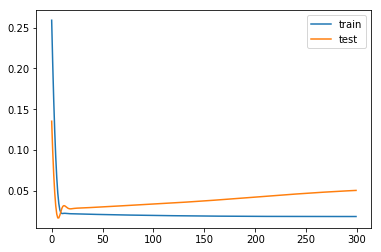

In [17]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
true_Y = Y.values[n_train+1:].reshape(yhat.shape[0],1)

In [19]:
# invert scaling for forecast
dfhat = np.concatenate((true_Y,yhat), axis = 1)
#inv_dfhat = scaler.inverse_transform(dfhat)
inv_yhat = inverse_minmax(dfhat[:,1],dfhat[:,0])

# calculate RMSE
rmse = np.sqrt(mean_squared_error(true_Y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 400.072


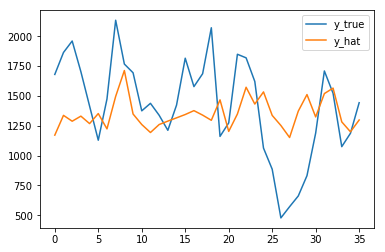

In [20]:
plt.plot(true_Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat')
plt.legend()

In [21]:
inv_yhat = pd.Series(inv_yhat)
inv_yhat.index = Y[n_train+1:,].index

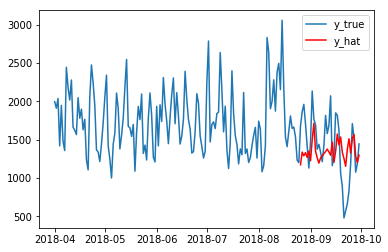

In [22]:
plt.plot(Y, label = 'y_true')
plt.plot(inv_yhat,label = 'y_hat', c='r')
plt.legend()